This code is to treat real data with all what I have learned previously to try to make a good EQE program calculator.

In [65]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy.polynomial

In [187]:
def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def closest_indx(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx     

def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1) #
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def FD_dist(HWHM, center, wavelengths_to_evaluate, height = 1):
    return height*(1/(1+np.exp((center-wavelengths_to_evaluate)/HWHM)))

def c_matrix_generator(
input_spectra_fit,                  #This is the full spectra to generate the c_matrix
Red_sweep = True,               #If you want a red sweap, this should be True, if it is False then blue sweep is calculated.
Derivative = False,             #If true, the output gives also the derivative of each spectra with respect to the wavelength. 
c_matrix_min_wl = 400,          #The minimum wavelength of the c_matrix spectras (and also the resulting EQE). Redomended value 400 because it is the minimum of EQE measures
c_matrix_max_wl = 1000,         #The maximum wavelength of the c_matrix spectras (and also the resulting EQE). Recomended value 1000
c_matrix_res_wl = 1,            #The wavelength resolution of the c_matrix spectras (and also the resultin EQE)
c_matrix_min_cutwl = 400,       #The minimum cuting wavelength of the c_matrix spectras
c_matrix_max_cutwl = 810,       #The maximum cutting wavelength of the c_matrix spectras
c_matrix_res_cutwl = 5,        #The cutting wavelength spacing of the c_matrix spectras
c_matrix_stepf_HWHM = 5        #Define the value of this parameter    
):
    
    full_spectra_irradiance_fit = input_spectra_fit
    c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)      #These are the wavelengths wherein the c_matrix is evaluated horizontally (its spectras, and therefore the EQE)
    c_matrix_cutwl = np.arange(c_matrix_min_cutwl, c_matrix_max_cutwl, c_matrix_res_cutwl)  #There are the wavelengths wehrein the c_matrix is evaluated verticlaly (therefore, the different cutting wavelengths)
    c_matrix_RS_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))                   #We initialize the red sweep and blue sweep metor matrix
    c_matrix_BS_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))
    c_matrix_full_spectra = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))               #And also the matrix containing all the full spectras for its multiplication with the motor matrix
    
    for i in range(len(c_matrix_full_spectra[:,0])):
        c_matrix_RS_motor[i,:] = FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)       #We define each row of the RS motor matrix with the FD stepfunction distribution
        c_matrix_BS_motor[i,:] = FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)      #The same for the BS motor, in this case the FWHM has to be negative in order to have the blue part of the spectra
        
        if Derivative:                                                                          #If the derivative mode is activated
            c_matrix_RS_motor_derivative = np.zeros(c_matrix_RS_motor.shape)                    #we also need to initialize both RS and BS motor derivative matrices
            c_matrix_BS_motor_derivative = np.zeros(c_matrix_BS_motor.shape)
            for i in range(len(c_matrix_full_spectra[:,0])):
                c_matrix_RS_motor_derivative [i,:] = FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)*(1-FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl))  #And calculate them
                c_matrix_BS_motor_derivative [i,:] = FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)*(1-FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl))

    c_matrix_spectra_single = np.zeros(c_matrix_wl.shape)                                           #We also do the same with the c_matrix full spectra previously fited with splines
    for j in range(len(c_matrix_wl)):                                                           #But in this case we need to make the average around each c_matrix_wl
        actual_wl = c_matrix_wl[j]
        actual_spectra_average = statistics.mean(full_spectra_irradiance_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
        c_matrix_spectra_single[j] = 0.1*actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
        #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in mA/cm^2 (in thsi case for the full spectra)
    for i in range(len(c_matrix_full_spectra[:,0])):
        c_matrix_full_spectra [i,:] = c_matrix_spectra_single                     

    if not Derivative:    #If the derivative option is False, we just return the c_matrix
        if Red_sweep:
            c_matrix = c_matrix_RS_motor*c_matrix_full_spectra
        else:
            c_matrix = c_matrix_BS_motor*c_matrix_full_spectra

        return (c_matrix, c_matrix_wl, c_matrix_cutwl)
    
    if Derivative:      #If the derivative option is True, we calculate and return the c_matrix_derivative
        if Red_sweep:
            c_matrix = c_matrix_RS_motor*c_matrix_full_spectra
            c_matrix_derivative = c_matrix_RS_motor_derivative*c_matrix_full_spectra
        else:
            c_matrix = c_matrix_BS_motor*c_matrix_full_spectra
            c_matrix_derivative = c_matrix_BS_motor_derivative*c_matrix_full_spectra

        return (c_matrix, c_matrix_derivative, c_matrix_wl, c_matrix_cutwl)


#This function takes a c_matrix and makes the derivative of it in the vertical direction (along the cuting wavelength direction)
def c_matrix_vertical_derivative (
c_matrix,               #The c_matrix in question
c_matrix_cutwl,         #The cutting wavelength vector of the c_matrix
s_factor=0              #The factor that 
):
    c_matrix_vderivative = np.zeros(c_matrix.shape)
    for j in range(len(c_matrix[0,:])):
        actual_spl_fit = interpolate.UnivariateSpline(c_matrix_cutwl, c_matrix[:,j], s=s_factor)
        c_matrix_vderivative [:,j] = -actual_spl_fit.derivative(n=1)(c_matrix_cutwl)

    return c_matrix_vderivative
    
#This function takes a c_matrix and puts a certain noise to it. 
def c_matrix_noise_adder(
c_matrix_input,             #The c_matrix to put noise
percentage):                #The maximum percentage of this noise (the noise added at each poing will be in between +- this percentage to the magnitude at that point)
    c_matrix_input_noise = np.zeros(c_matrix_input.shape)
    for j in range(len(c_matrix_input[:,0])):
        for i in range(len(c_matrix_input[0,:])):
            c_matrix_input_noise[j,i] = c_matrix_input[j,i]*(100+percentage*np.random.random_sample())/100
    
    return c_matrix_input_noise

#This function is useful to plot all the spectras of a given c_matrix
def c_matrix_plotter(
c_matrix,                   #The c_matrix to plot
c_matrix_wl,                #The correponding c_matrix wavelength vector
legend = False,             #True for plotting the legend
concret_spectra = False,    #If you want to plot a concret spectra, just put here a number or a list of numbers
plotsize = (14,6)):        #True for plotting the legend
    if not concret_spectra:
        fig, ax = plt.subplots(figsize=plotsize)
        for i in range(len(c_matrix[:,0])):
            ax.plot(c_matrix_wl,c_matrix[i,:])
        plt.xlabel('Wavelength [nm]')
    if concret_spectra:
        fig, ax = plt.subplots(figsize=plotsize)
        for i in concret_spectra:
            ax.plot(c_matrix_wl,c_matrix[i,:], label=str(i))
        plt.xlabel('Wavelength [nm]')
        plt.legend()
#This function is used to calculate the Jsc
def Jsc_calculator(
full_spectra_irradiance,        #The full spectra irradiance imput
wl_resolution,                  #The wavelenegth resolution of the calculations
real_EQE_interp,                #The interpolation function of the measured EQE
noise_percentage = 0            #The noise percentage added to the Jsc curve
):
    calculated_Jsc_c_matrix_RS, calculated_Jsc_c_matrix_wl_RS, calculated_Jsc_c_matrix_cutwl_RS = c_matrix_generator(full_spectra_irradiance, Red_sweep=True, Derivative = False, c_matrix_res_wl=wl_resolution)
    calculated_Jsc_c_matrix_BS, calculated_Jsc_c_matrix_wl_BS, calculated_Jsc_c_matrix_cutwl_BS = c_matrix_generator(full_spectra_irradiance, Red_sweep=False, Derivative = False, c_matrix_res_wl=wl_resolution)
    calculated_Jsc_RS = np.zeros(len(calculated_Jsc_c_matrix_RS[:,0]))
    calculated_Jsc_BS = np.zeros(len(calculated_Jsc_c_matrix_BS[:,0]))
    for i in range(len(calculated_Jsc_c_matrix_RS[:,0])):
        calculated_Jsc_RS[i] = sum(calculated_Jsc_c_matrix_RS[i,:]*real_EQE_interp(calculated_Jsc_c_matrix_wl))
        calculated_Jsc_RS[i] = calculated_Jsc_RS[i]*(100+noise_percentage*np.random.random_sample())
        calculated_Jsc_BS[i] = sum(calculated_Jsc_c_matrix_BS[i,:]*real_EQE_interp(calculated_Jsc_c_matrix_wl))
        calculated_Jsc_BS[i] = calculated_Jsc_BS[i]*(100+noise_percentage*np.random.random_sample())
    return calculated_Jsc_RS, calculated_Jsc_BS, calculated_Jsc_c_matrix_cutwl_RS, calculated_Jsc_c_matrix_cutwl_BS 

Load the measurements data (Jsc vs cutwl and EQE)

In [4]:
#We load the measurements:
device_filename = 'Device 0830ThY61 - L'    #Here write the folder name of your device
cell_filename = 'L.02'                      #Here put the folder name of the cell of your device
measures_filepath = os.path.join(os.getcwd(), 'RainbowMeasures', device_filename, 'TXT files', cell_filename)
measures_filepath_list = os.listdir(measures_filepath)
for file in measures_filepath_list:
    if '.txt' in file:
        measures_filepath = os.path.join(measures_filepath, file)
        print(measures_filepath)

measurement_data= np.loadtxt(measures_filepath, skiprows=1)   
measure_divwl = measurement_data[:,0]
measure_Jsc = -0.1*measurement_data[:,2]
measure_Jsc = numpy.polynomial.polynomial.Polynomial.fit(measure_divwl, measure_Jsc, 10)(measure_divwl)

for i in range(len(measure_Jsc)):
    measure_Jsc[i] = measure_Jsc[i]-measure_Jsc[0]


measure_divwl = measurement_data[:,0]
min_cutwl = np.min(measure_divwl)
#min_cutwl = 410
max_cutwl = np.max(measure_divwl)
inc_cutwl = abs(min_cutwl-max_cutwl)/(len(measure_divwl)-1)
print(min_cutwl, max_cutwl)

c:\Users\UX490UA\Documents\GitHub\SOLS-EQE\Numeric method - second try\RainbowMeasures\Device 0830ThY61 - L\TXT files\L.02\MCV.211005.0830ThY61.1Sun_210930..Red Sweep Opening.txt
400.0 810.0


Load spectra matrix and compute c_matrix

In [255]:
spectras_folder = '30SetembreCalibrationSpectras' #Name of the folder with the blue and red calibration spectras
txt_filelist_RS = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Red Sweep Opening'))   #Remember to add 0 to the firsts file names!!
txt_filelist_BS = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Blue Sweep Opening')) #Remember to add 0 to the firsts file names!!
int_time = 0.001*0.6
k_filepath = 'flame_to_irradiance_calibrationfile.txt'
spectra_data_RS = None
spectra_data_BS = None
bg_spectra_RS = np.loadtxt(os.path.join(spectras_folder, 'Red Sweep Opening',txt_filelist_RS[0]), skiprows=1)
bg_spectra_BS = np.loadtxt(os.path.join(spectras_folder, 'Blue Sweep Opening', txt_filelist_BS[0]), skiprows=1)


for i in range(len(txt_filelist_RS)):
    actual_filepath = os.path.join(spectras_folder, 'Red Sweep Opening', txt_filelist_RS[i])
    load_spectra = np.loadtxt(actual_filepath, skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra_RS[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data_RS = actual_irradiance_spectra
    else:
        spectra_data_RS = np.dstack((spectra_data_RS, actual_irradiance_spectra))

for i in range(len(txt_filelist_BS)):
    load_spectra = np.loadtxt(os.path.join(spectras_folder, 'Blue Sweep Opening',txt_filelist_BS[i]), skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra_BS[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data_BS = actual_irradiance_spectra
    else:
        spectra_data_BS = np.dstack((spectra_data_BS, actual_irradiance_spectra))

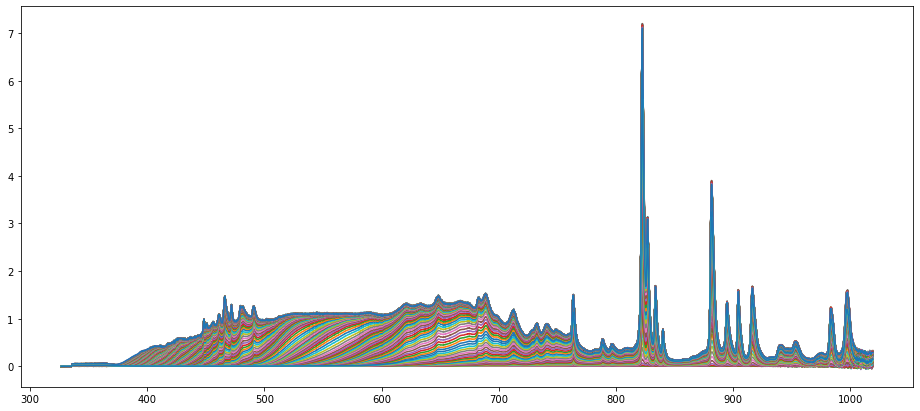

In [256]:
fig, ax = plt.subplots(figsize=(16,7))
for j in range(len(spectra_data_RS[0,0,:])):
    ax.plot(spectra_data_RS[:,0,j], spectra_data_RS[:,1,j])


In [257]:
motor_divwl_relation_filename = 'Dividing Wavelength To Motor Position Calibration File_October2021.txt'
motor_divwl_relation = np.loadtxt(os.path.join(spectras_folder, motor_divwl_relation_filename), skiprows=1) #Dividing Wavelength To Motor Position Calibration File.txt
BS_divwl_relation = np.zeros(motor_divwl_relation[:,0:2].shape)
BS_divwl_relation[:,0] = motor_divwl_relation[:,0]
BS_divwl_relation[:,1] = motor_divwl_relation[:,2]
RS_divwl_relation = np.zeros(BS_divwl_relation.shape)
RS_divwl_relation [:,0] = motor_divwl_relation[:,0]
RS_divwl_relation [:,1] = motor_divwl_relation[:,1]
calibration_motor_position = np.linspace(0,50,251) #Here we need to define the motor position for each spectra.
#print(calibration_motor_position)

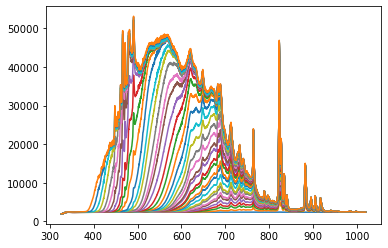

In [321]:
#Here we construct the c_matrix puting the spectra of the calibration files where the motor was closer to the cuting wavelength. 
c_matrix_min_wl = 400
c_matrix_max_wl = 1000 #round(min(max(measure_divwl[:]), max(spectra_matrix_cutwl))[0])
c_matrix_res_wl = 1
fit_spectra_sfactor = 2
fit_columns_sfactor = 0.003
c_matrix_cutwl = measure_divwl

c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)
fig, ax = plt.subplots()
c_matrix_RS = np.zeros((len(c_matrix_cutwl),len(c_matrix_wl)))
c_matrix_BS = np.zeros((len(c_matrix_cutwl),len(c_matrix_wl)))
for i in range(len(c_matrix_RS[:,0])):
    actual_cutwl = c_matrix_cutwl[i]
    RS_actual_index = closest_indx(RS_divwl_relation[:,0], actual_cutwl)
    RS_closest_motorpos = closest(calibration_motor_position[:], RS_divwl_relation[RS_actual_index,1])
    RS_file = [s for s in txt_filelist_RS if '_'+str(format(RS_closest_motorpos, '.2f')) in s]
    RS_actual_spectra = np.loadtxt(os.path.join(spectras_folder, 'Red Sweep Opening',RS_file[0]), skiprows=1)
    ax.plot(RS_actual_spectra[:,0], RS_actual_spectra[:,1])
    RS_actual_spectra_fit = interpolate.UnivariateSpline(RS_actual_spectra[:,0], RS_actual_spectra[:,1] - bg_spectra_RS[:,1], s=2)
    #print(RS_file, actual_cutwl)
    for j in range(len(c_matrix_RS[0,:])):
        actual_wl = c_matrix_wl[j]
        actual_spectra_average = statistics.mean(RS_actual_spectra_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
        c_matrix_RS[i,j] = 0.1*actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
        #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in mA/cm^2 (in thsi case for the full spectra)
    


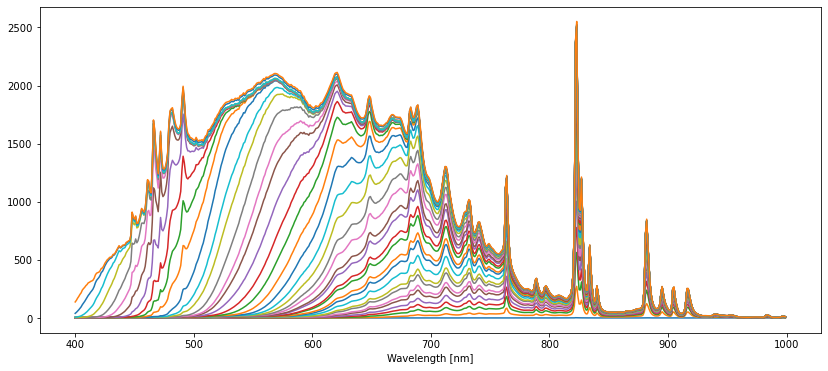

In [323]:
c_matrix_plotter(c_matrix_RS, c_matrix_wl)

Now we fit the measured Jsc with an spline

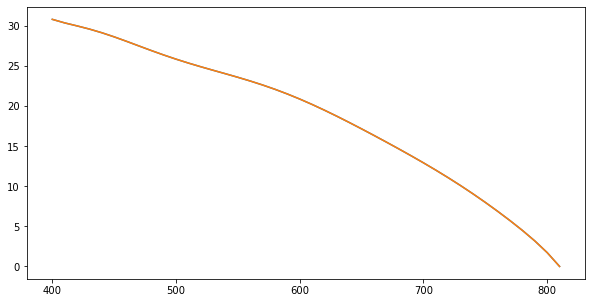

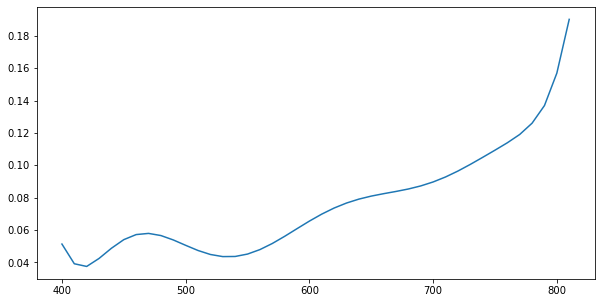

In [324]:
measure_Jsc_fit=interpolate.UnivariateSpline(np.flip(measure_divwl), np.flip(measure_Jsc), s=0)
fig, ax =plt.subplots(figsize=(10,5))
ax.plot(measure_divwl, measure_Jsc)
ax.plot(measure_divwl, measure_Jsc_fit(measure_divwl))

fig, ax =plt.subplots(figsize=(10,5))
ax.plot(measure_divwl, -measure_Jsc_fit.derivative(n=1)(measure_divwl))

measure_Jsc_derivative = -measure_Jsc_fit.derivative(n=1)(measure_divwl)

True


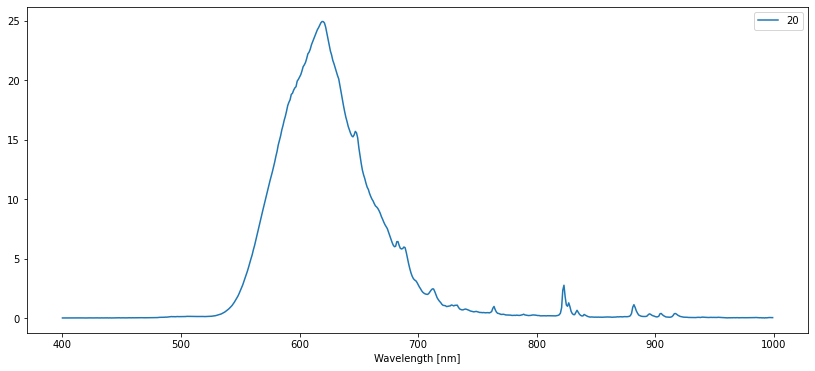

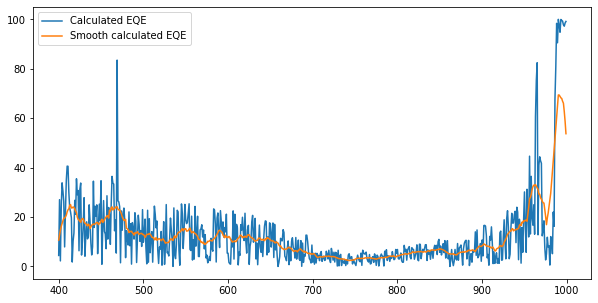

In [328]:
#c_matrix_derivative_noise = c_matrix_noise_adder(c_matrix_derivative, 0)
c_matrix_vderivative = c_matrix_vertical_derivative(np.flip(c_matrix_RS,axis=0), np.flip(measure_divwl),s_factor=0)
# for i in range(len(c_matrix_vderivative[:,0])):
#     for j in range(len(c_matrix_vderivative[0,:])):
#         if c_matrix_vderivative[i,j] <= 0:
#             c_matrix_vderivative[i,j] = 0
c_matrix_plotter(np.flip(c_matrix_vderivative), np.flip(c_matrix_wl), concret_spectra=[20])
EQE_linearsolution_all = optimize.lsq_linear(np.flip(np.flip(c_matrix_vderivative,axis=0),axis=1),134000*np.flip(measure_Jsc_derivative), bounds=(0,100), lsq_solver='exact', tol=0.01, method='trf', max_iter=20000)
#print(EQE_linearsolution_all)
EQE_linearsolution = EQE_linearsolution_all.x
print(EQE_linearsolution_all.success)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(c_matrix_wl, EQE_linearsolution, label='Calculated EQE')
ax.plot(c_matrix_wl, smooth(EQE_linearsolution,20), label='Smooth calculated EQE')
#ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
plt.legend()
#plt.ylim(0,100)

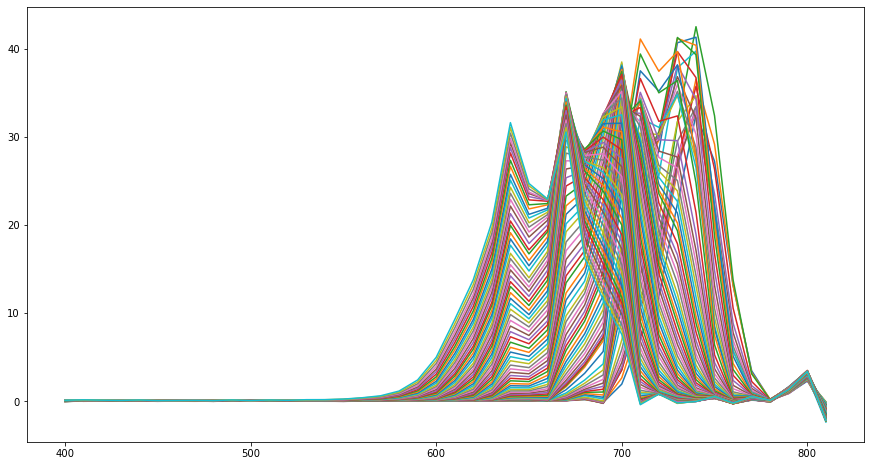

In [331]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(70,160):
    plt.plot(measure_divwl, c_matrix_vderivative[:,i])